<img src="images/satrday-cover.png" width="700">


### George Mount
### Stringfest Analytics
### [stringfestanalytics.com](https://georgejmount.com)

# Objectives for today

- Why "R-Powered Excel?"
- A tour of the landscape
- Write a formatted data frame, plot and regression results to a workbook
- Resources for future learning

# Follow along!

Run this notebook on Binder at the [GitHub repo](https://github.com/stringfestdata/satrday-r-powered-excel)

## R, Excel and the "data analytics stack"


<img src="images/data-analytics-stack.png" width="400">


Source: ["The Data Products Venn Diagram," Data Community DC](https://www.datacommunitydc.org/blog/2013/09/the-data-products-venn-diagram)

# CRAN does not disappoint for R/Excel interfaces:

- `gdata` (Perl required)
- `readxl` 
- `openxlsx` 
- `writexls` (Perl required)
- `XlConnect` (rJava required)
- `xlsx` (rJava required)
- `excel.link`
- etc...


## For most features with fewest external dependencies go with...

- `readxl`: A *read-only* Excel package from the `tidyverse`
- `openxlsx`: Full-service "R-powered Excel"  (The focus of this workshop)

# The basic workflow:

- Create a blank workbook with `createWorkbook()`
- Add worksheets with `addWorksheet()`
- Add various data frames, plots, summaries, etc.
- Save workbook with `saveWorkbook()`

Let's give it a spin with the `mpg` dataset:

In [1]:
library(openxlsx)
library(tidyverse)
library(broom)

mpg = read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/mpg.csv')

head(mpg)

Warning message:
"package 'tidyverse' was built under R version 3.6.2"
-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.2.1     v purrr   0.3.3
v tibble  2.1.3     v dplyr   0.8.3
v tidyr   1.0.0     v stringr 1.4.0
v readr   1.3.1     v forcats 0.4.0

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Parsed with column specification:
cols(
  mpg = col_double(),
  cylinders = col_double(),
  displacement = col_double(),
  horsepower = col_double(),
  weight = col_double(),
  acceleration = col_double(),
  model_year = col_double(),
  origin = col_character(),
  name = col_character()
)



mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
18,8,307,130,3504,12.0,70,usa,chevrolet chevelle malibu
15,8,350,165,3693,11.5,70,usa,buick skylark 320
18,8,318,150,3436,11.0,70,usa,plymouth satellite
16,8,304,150,3433,12.0,70,usa,amc rebel sst
17,8,302,140,3449,10.5,70,usa,ford torino
15,8,429,198,4341,10.0,70,usa,ford galaxie 500


### The `data` worksheet

First we'll set up objects referring to our workbook and worksheet, respectively. 

In [2]:
# Add workbook
wb <- createWorkbook()

# Add worksheet of raw data
data_sheet <- addWorksheet(wb, sheetName = 'data')

Next, we'll use the `writeDataTable()` function to write `mpg` to this worksheet as an Excel table. 

In [3]:
# Exclude row names
writeDataTable(wb, sheet = data_sheet, x = mpg, rowNames = FALSE)

Pretty much anything you could do to a workbook from Excel, you can do from `openxlsx`. 

For example, let's apply conditional formatting to the `name` column for observations starting with the phrase `ford`:

In [4]:
# Create conditional formatting style
fordStyle <- createStyle(fontColour = "#006100", bgFill = "#C6EFCE")

conditionalFormatting(wb, sheet = data_sheet, 
                  # Find the index position of weight
                  cols = which(colnames(mpg) == 'name'),
                  # Format from rows 2 through the end of mpg (account for header)
                  rows = 2:(nrow(mpg) + 1),
                  # What type of rule is this?
                  type = 'beginsWith',
                  # What is the rule?
                  rule = 'ford',
                  # Apply style
                  style = fordStyle)

ERROR: Error in conditionalFormatting(wb, sheet = data_sheet, cols = which(colnames(mpg) == : Invalid type argument.  Type must be one of 'expression', 'colourScale', 'databar', 'duplicates' or 'contains'


### The `analysis` worksheet

I would also like to include an `analysis` worksheet including regression results and a scatterplot of the relationship between `mpg` and `weight`. 

We can set up a new worksheet, add the results of the regression with `writeData()` and add the scatterplot with `writePlot()` 

In [6]:
# Set up a new worksheet 
analysis_sheet <- addWorksheet(wb, sheetName = 'analysis')

In [7]:
# Build a tidy lm regression output
mpg_lm <- lm(mpg ~ weight, data = mpg)
mpg_lm_tidy  <-  tidy(mpg_lm)

mpg_lm_tidy

# Add the table to this worksheet
writeDataTable(wb, sheet = analysis_sheet, x = mpg_lm_tidy, rowNames = FALSE)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),46.31736442,0.7952452295,58.24287,2.753438e-196
weight,-0.00767661,0.0002574869,-29.81360,2.972800e-103


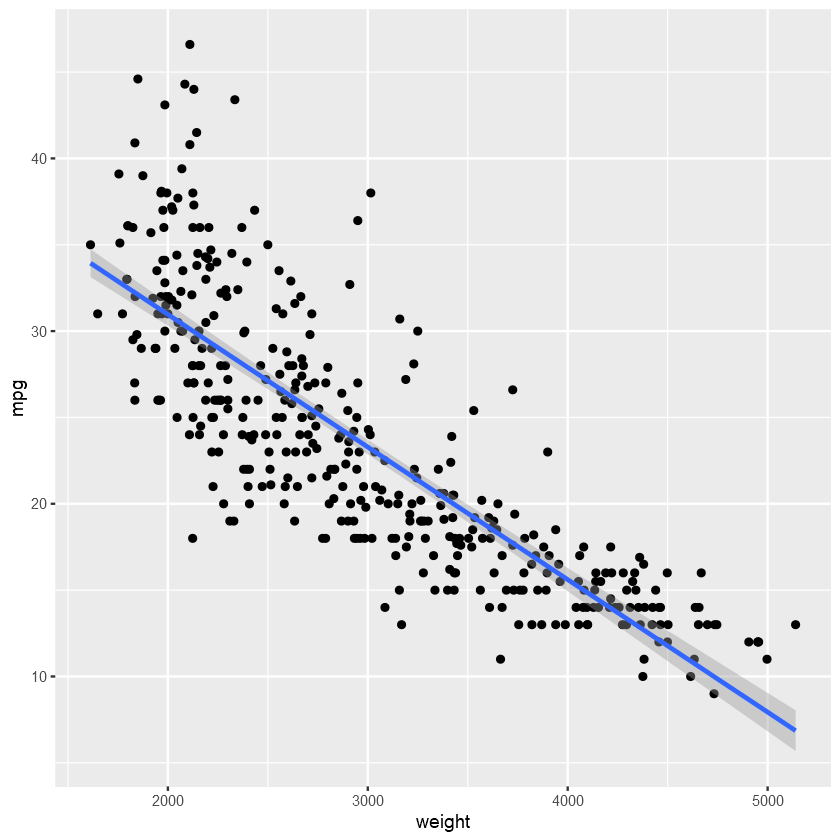

In [8]:
# Visualize the results
ggplot(data = mpg, aes(x = weight, y = mpg))+
    geom_point()+
    geom_smooth(method = 'lm')

# Add the image to the worksheet, set the placement
insertPlot(wb, sheet = analysis_sheet, startRow = 5, startCol = "A", width = 4, height = 4)

### Admire our work, part 1

OK, let's save and view our work. By default, `saveWorkbook()` will put the file in our working directory.

Let's take a look at the finished output in Excel.

In [10]:
mpg_report = 'mpg-report.xlsx'

# save workbook to working directory
saveWorkbook(wb = wb, file = mpg_report, overwrite = TRUE)

Note: zip::zip() is deprecated, please use zip::zipr() instead



It's pretty good! But as a matter of fact I would like to do a few more things to the workbook:

- Freeze panes in each worksheet
- Autofit the column widths in each worksheet
- Format the `weight` column in thousands and `acceleration` with a decimal in the `data` worksheet. 

The connection from R to our workbook is still open in our session; as long as our workbook remains closed, these additinoal changes will be applied to the workbook.

Let's give it a go:

In [ ]:
for (sheet in getSheetNames(mpg_report)){
    freezePane(wb, sheet = sheet, firstRow = TRUE)
}

In [ ]:
thousands <- createStyle(numFmt = "#,##0")

addStyle(wb, sheet = data_sheet, style = thousands, cols = which(colnames(mpg) == 'weight'), rows = 1:nrow(mpg))

In [ ]:
setColWidths(wb, sheet = data_sheet, cols = ncol(mpg), widths = "auto")

Let's try this again!

This time, let's use `openXL()` to launch the workbook directly from R.

In [ ]:
mpg_report = 'mpg-report.xlsx'

saveWorkbook(wb = wb, file = mpg_report, overwrite = TRUE)

openXL(mpg_report)

### Writing multiple sheets

Finally, we can write a _list_ of data frames to a workbook with the `write.xlsx()` function. For example, let's split our `mpg` dataset by `origin` and write each result a worksheet. We can set them to be tables in Excel with `asTable = TRUE`.

In [15]:
mpg_list <- split(mpg, mpg$origin)
mpg_list

mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
26,4,97,46,1835,20.5,70,europe,volkswagen 1131 deluxe sedan
25,4,110,87,2672,17.5,70,europe,peugeot 504
24,4,107,90,2430,14.5,70,europe,audi 100 ls
25,4,104,95,2375,17.5,70,europe,saab 99e
26,4,121,113,2234,12.5,70,europe,bmw 2002
28,4,116,90,2123,14.0,71,europe,opel 1900
30,4,79,70,2074,19.5,71,europe,peugeot 304
30,4,88,76,2065,14.5,71,europe,fiat 124b
27,4,97,60,1834,19.0,71,europe,volkswagen model 111


In [20]:
for (i in mpg_list){
    plot(mpg_list[i]$weight)
}

ERROR: Error in mpg_list[i]: invalid subscript type 'list'


In [30]:
mpg_list[['japan']['weight']]

ERROR: Error in parse(text = x, srcfile = src): <text>:1:19: unexpected '['
1: mpg_list[['japan'][
                      ^


In [33]:
mpg_list[[japan]][[weight]]

ERROR: Error in eval(expr, envir, enclos): object 'weight' not found


In [ ]:
w

In [16]:
mpg_categories = 'mpg-origins.xlsx'
write.xlsx(x = mpg_list, file = 'mpg-origins.xlsx', asTable = TRUE)




[1] "europe" "japan"  "usa"

In [ ]:
# Let's include plots in each worksheet too

In [ ]:
openXL(mpg_categories)

# Questions?

# Recommended resources:  



## 1. `browseVignettes()`

In [ ]:
# This takes a while to run in Jupyter...
browseVignettes(package = c('readxl', 'openxlsx'))

## 2. [R & Excel -- LondonR meetup presentation by UBS analysts](https://www.londonr.org/wp-content/uploads/sites/2/presentations/LondonR_-_R_&_Excel_-_David_Jessop_-_20170713.pdf)


![UBS R Excel](images/ubs-r-excel.png)

## 3. "How to run R in Jupyter?"

Download `IRkernel` package ([instructions here](https://irkernel.github.io/installation/))

## 4. "How to run R with Binder?"

- You need a `runtime.txt` file and optionally an `install.R` file
- [Full instructions here](https://github.com/binder-examples/r)

# THANK YOU

### George Mount
### Stringfest Analytics
### [stringfestanalytics.com](https://georgejmount.com)
### [linkedin.com/in/gjmount](https://www.linkedin.com/in/gjmount/)
